In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import hdbscan
import umap
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer

# Cargar el dataset
file_path = r"C:\Users\Omar\Downloads\Projecte_ML\dataset.csv" 
df = pd.read_csv(file_path)

# Ver las primeras filas
df.head()


c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
0,2,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,34,61,17,13,20
1,4,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,7,33,14,11,26
2,9,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,25,73,24,7,23
3,10,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,17,48,16,10,21
4,13,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,14,46,22,14,23


In [2]:
# Eliminar columnas no relevantes
df = df.drop(columns=['id'])


In [3]:
# Seleccionar las columnas numéricas para análisis
df_num = df[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]

# Estandarizar los datos
scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)


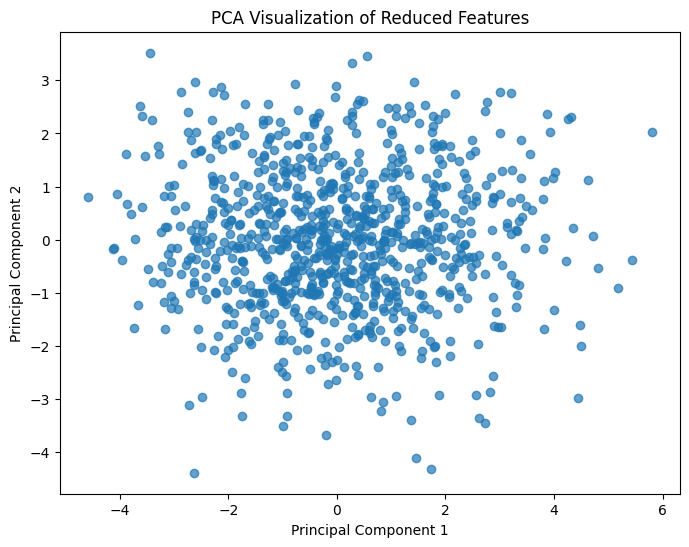

In [4]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_num_scaled)

# Visualización de PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.7)
plt.title("PCA Visualization of Reduced Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


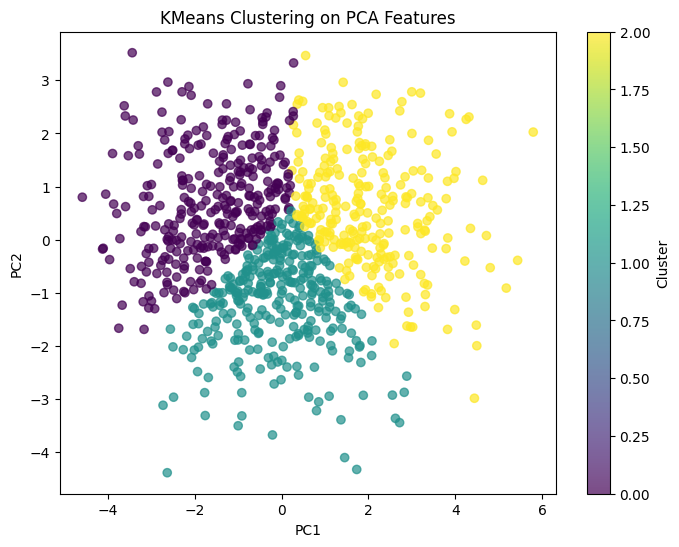

Silhouette Score (KMeans): 0.3322


In [5]:
# Aplicar KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(pca_features)

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
plt.title("KMeans Clustering on PCA Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Evaluar el modelo
print(f"Silhouette Score (KMeans): {silhouette_score(pca_features, clusters_kmeans):.4f}")


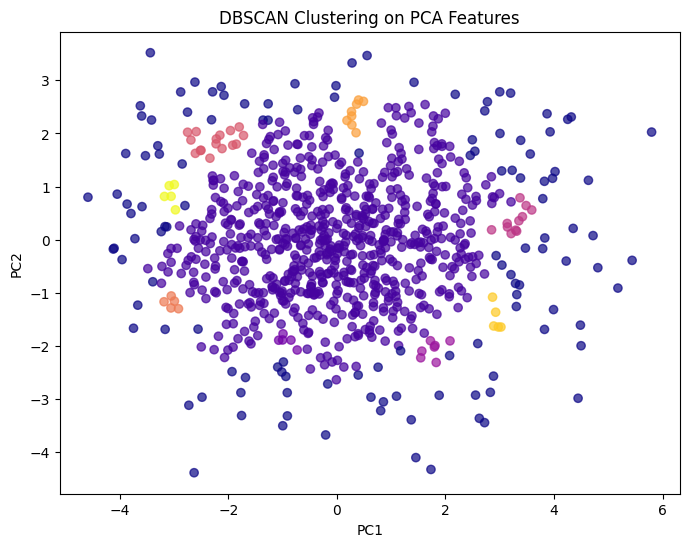

Davies-Bouldin Score (DBSCAN): 0.6514
Calinski-Harabasz Score (DBSCAN): 23.6615


In [6]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters_dbscan = dbscan.fit_predict(pca_features)

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_dbscan, cmap='plasma', alpha=0.7)
plt.title("DBSCAN Clustering on PCA Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Filtrar outliers (-1) y evaluar
mask = clusters_dbscan != -1
if len(set(clusters_dbscan[mask])) > 1:
    print(f"Davies-Bouldin Score (DBSCAN): {davies_bouldin_score(pca_features[mask], clusters_dbscan[mask]):.4f}")
    print(f"Calinski-Harabasz Score (DBSCAN): {calinski_harabasz_score(pca_features[mask], clusters_dbscan[mask]):.4f}")
else:
    print("DBSCAN no encontró suficientes clusters.")


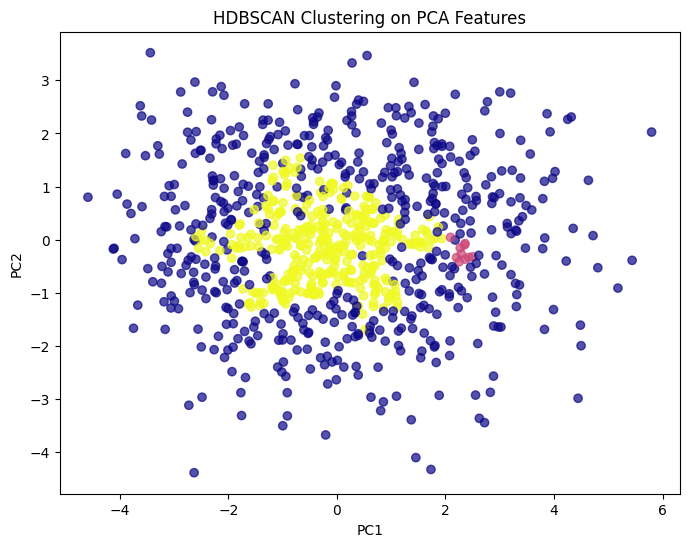

In [7]:
# Aplicar HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusters_hdbscan = clusterer.fit_predict(pca_features)

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_hdbscan, cmap='plasma', alpha=0.7)
plt.title("HDBSCAN Clustering on PCA Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


 97%|=================== | 2575/2658 [00:19<00:00]       

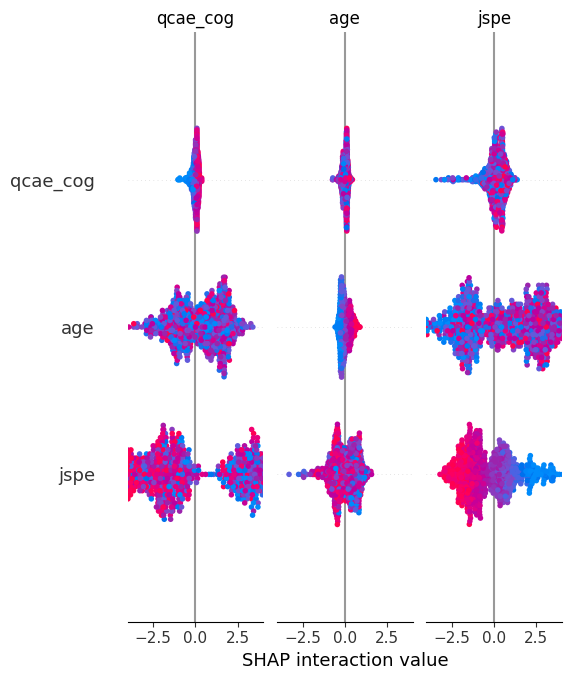

In [8]:
# Entrenar modelo XGBoost para explicar clusters
X = df_num_scaled
y = clusters_kmeans  # Usar etiquetas de KMeans

# Crear modelo y entrenar
model = xgb.XGBClassifier(random_state=42)
model.fit(X, y)

# Generar valores SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Visualizar SHAP
shap.summary_plot(shap_values, X, feature_names=df_num.columns)


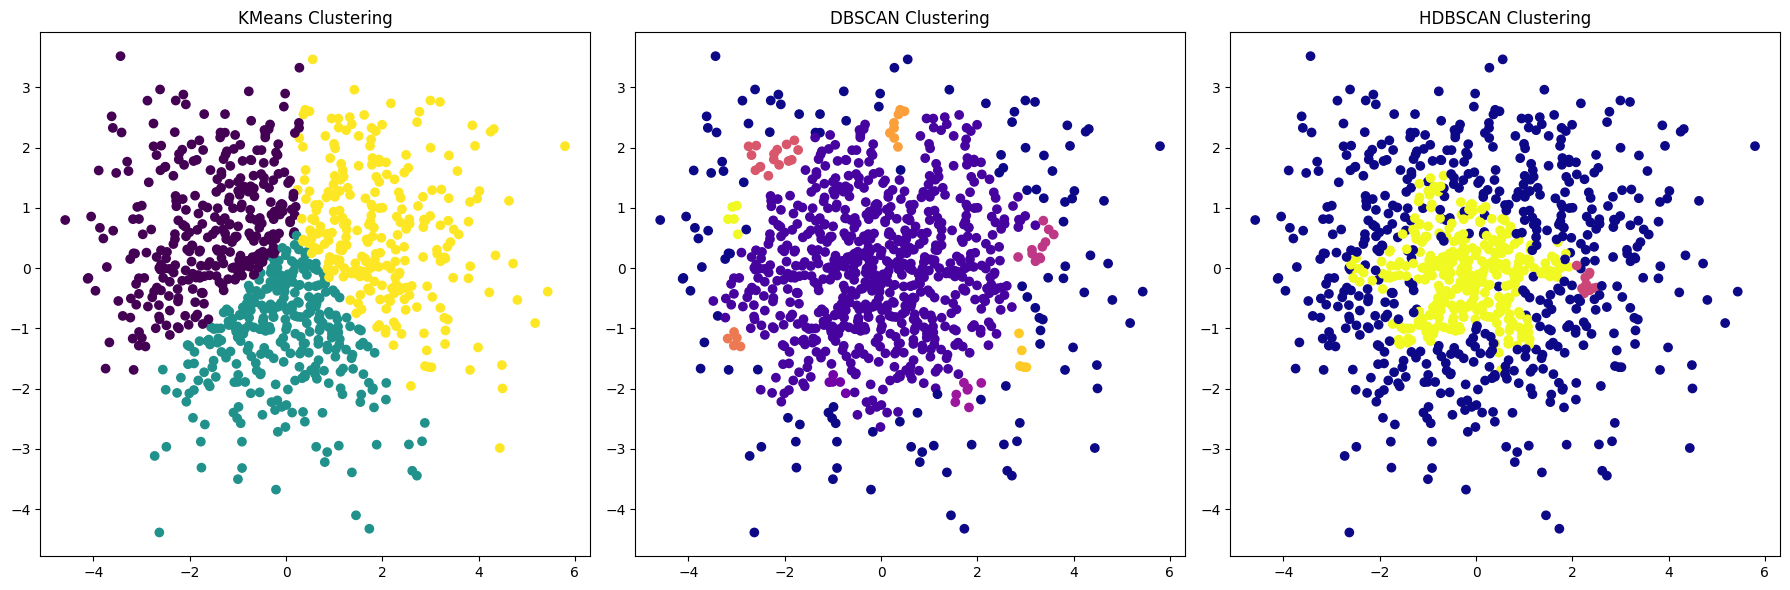

In [9]:
# Crear subplots para comparar métodos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KMeans
axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_kmeans, cmap='viridis')
axes[0].set_title("KMeans Clustering")

# DBSCAN
axes[1].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_dbscan, cmap='plasma')
axes[1].set_title("DBSCAN Clustering")

# HDBSCAN
axes[2].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters_hdbscan, cmap='plasma')
axes[2].set_title("HDBSCAN Clustering")

plt.tight_layout()
plt.show()
